# Unit Commitment with Energy Storage

This is an extended version of the sandbox unit comitment problem used in the previous two notebooks. 

The model consists aus three heat generators that have to cover a heat demand. The generators are:
* a gasfired heat only boiler
* a back pressure steam turbine 
* a thermal heat storage

A forecast for the heat load that needs to be covered is available and the models purpose is to find the
optimal schedule to cover this load giving another forecast for the electricity prices.

## Configuration and Scenarios

The configuration to this code is saved as an Excel Workbook. The workbook serves as input and contains both
the constant plant characteristics and the forecasts. It can therefore be used to try out different scenarios.

## Code Explanation

In contrast to the previous three notebooks, this one uses functions that are defined first and then called in different cells later on. This is a more typical approach when developing these kind of models: Implement the next small step as a function, when it works create another cell and use the function. 

In [1]:
#%% Imports
# pandas for tables and timeseries, 
# Numpy for Numeric calculations,
# Matplotlib for plotting,
# pulp for linear program definition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, LpInteger, LpStatus, value,LpAffineExpression

# little helper to interact with excel parameter file
from tools import update_excel, read_config

# This command makes the plots in this workbook interactive
%matplotlib inline

In [2]:
# Test read configuration file
filename='4_optimization_model_with_storage_input.xlsx'
params, ts = read_config(filename)

# Display input data
print(params)
ts.head()

Parameter
Qlmax     30.00
Q1max     30.00
P2max     20.00
P2min      4.00
SKZ2       0.32
k_1       10.00
k_20       0.50
k_21      35.00
k_sp       4.00
e3max      8.00
estart     4.00
Name: Wert, dtype: float64


,Heatload,EEX
Time,,
2018-12-21 00:00:00,0.882473,17.229794
2018-12-21 01:00:00,0.871168,11.550196
2018-12-21 02:00:00,0.868035,10.916899
2018-12-21 03:00:00,0.866146,9.808522
2018-12-21 04:00:00,0.871579,10.373611


In [3]:
# Build and solve the optimization problem
def build_problem(params, ts):
    
    #%% Einlesen und Verarbeiten der Parameter aus der Excel Datei
    tsindex=ts.index
    ts = ts.reset_index()    
    
    # Scale timeseries
    ts['Heatload']=ts['Heatload']*params['Qlmax']
    ts['EEX']=ts['EEX'] / ts['EEX'].mean() * params['k_sp']
    #%% Definition des Problems als Lineare Minimierungsproblem
    
    prob = LpProblem("Advanced Unit Commitment Problem",LpMinimize)
    
    nts=ts.shape[0]
    
    # Inititalize variables with boundaries and store them in a list (one per timestep)
    
    # These variables are normalized to nominal capacity so range [0,1]
    q1 = [LpVariable(f"q1{t}", 0, 1) for t in range(nts)]
    q2 = [LpVariable(f"q2{t}", 0, 1/params['SKZ2']) for t in range(nts)]
    p2 = [LpVariable(f"p2{t}", 0, 1) for t in range(nts)]
    q3 = [LpVariable(f"q3{t}", -1, 1) for t in range(nts)]
    
    # This is the one binary variable for the turbine operating state
    z2 = [LpVariable(f"z2{t}", 0, 1, LpInteger) for t in range(nts)]
    
    # Storage capacity is stored in hours of full heat load coverage
    e3 = [LpVariable(f"e3{t}", 0, params['e3max']) for t in range(nts)]
    
    objective={}
    
    # Production cost of unit 1 (heat only boiler)
    objective.update({q1[t]:params['Q1max']*params['k_1'] for t in range(nts)})
    
    # Production cost of unit 2 (increase cost)
    objective.update({p2[t]:params['P2max']*(params['k_21']-ts.loc[t, 'EEX']) for t in range(nts)})
    
    # Production cost of unit 2 (constant operating cost)
    objective.update({z2[t]:params['P2max']*params['k_20'] for t in range(nts)})
    
    # Add objectives to problem
    prob += LpAffineExpression(objective), "Objective function, Linear Production Cost"
    
    # These are the conditions per timestep
    for t in range(nts):
        
        # Load constraint
        prob += q1[t]*params['Q1max'] \
        + p2[t]*params['P2max']/params['SKZ2']  \
        + q3[t]*params['Qlmax'] == ts.loc[t, 'Heatload'], f"Load constraint t={t}"
        
        # Heat storage level
        prob += e3[t] == params['estart'] + sum(q3[i] for i in range(0,t+1)), f"Heat storage contraint t={t}"
        
        # Steam turbine characteristic
        prob += p2[t] == q2[t] * params['SKZ2']
        
        # Minimum Power
        prob += p2[t]*params['P2max'] >= z2[t]*params['P2min']
        
        # Maximum Power
        prob += p2[t] <= z2[t]
        
    # Storage level at last step
    prob += e3[-1] == params['estart']    
    
    return prob    

In [4]:
# test build_problem
prob = build_problem(params, ts.copy())
print(f"Problem has {len(prob.constraints)} constraints and {len(prob.variables())} variables")
print(f"or {len(prob.variables())/len(ts):.0f} variables and {len(prob.constraints)/len(ts):.0f} constraints per timestep with a total number of {len(ts)} timesteps")

Problem has 241 constraints and 288 variables
or 6 variables and 5 constraints per timestep with a total number of 48 timesteps


In [5]:
def solve(prob, ts):
    # Löse das Problem
    prob.solve()

    print("Status:", LpStatus[prob.status])

    # Each of the variables is printed with it's resolved optimum value
    raw_result={}
    for v in prob.variables():
        raw_result[v.name]=v.varValue

    # The optimised objective function value is printed to the screen
    print(f"Total cost of production is {value(prob.objective):.0f} EUR.")

    #%% Construct result frame

    # Gets the variable values back as timeseries in correct order of timesteps given the variable name (key)
    get_series = lambda key: pd.Series({int(k.replace(key,'')):raw_result[k] for k in raw_result.keys() if k.startswith(key)}, name=key)

    # selection of variables to be exported to excel file
    result_vars=['q1', 'q2', 'q3', 'p2', 'e3', 'z2']

    # save as dataframe
    df = pd.concat([get_series(k) for k in result_vars], axis=1, keys=result_vars).sort_index()

    df.index = ts.index

    return (LpStatus[prob.status],value(prob.objective), df)

In [6]:
# test solve()
result = solve(prob, ts)

Status: Optimal
Total cost of production is 13045 EUR.


In [7]:
def process_results(filename, result, params, ts):
    update_excel(result[2], filename, 'schedule')
    
    # show thermal production schedule in first plot
    result[2][['q1','q2','q3','e3']].plot(title='Thermal production schedule')
    
    plt.subplots()
    # in the second I want EEX prive and electric prodution
    ax21=ts['EEX'].plot(color='red')
    ax22 = ax21.twinx()
    result[2]['p2'].plot(ax=ax22)
    ax22.figure.legend(loc='center left')
    ax22.set_title('Electric production schedule (blue) and EEX price (red)')

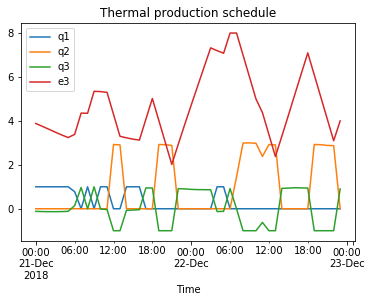

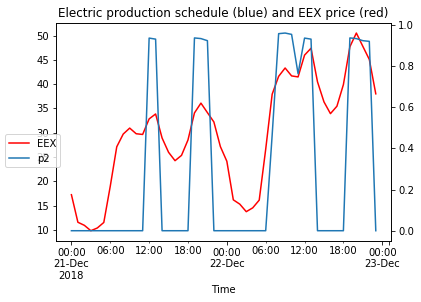

In [8]:
# test process_results
process_results(filename, result, params, ts)

In [9]:
def build_and_run(filename):
    params, ts = read_config(filename)
    problem = build_problem(params, ts.copy())
    result = solve(problem, ts)
    process_results(filename, result, params, ts)

Status: Optimal
Total cost of production is 13045 EUR.


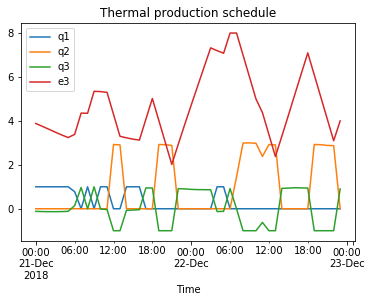

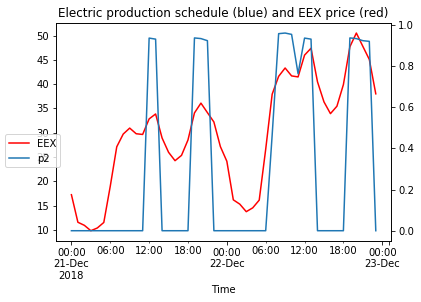

In [10]:
#%% Call of the defined functions
build_and_run('4_optimization_model_with_storage_input.xlsx')     